Set True to save the figures.

In [21]:
save = False

In [22]:
import numpy as np # scientific computing
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # reading images
from skimage.color import rgb2gray # converting rgb images to grayscale

Read images and convert them to grayscale.

In [23]:
# Load all and convert to grey scales 
# edge 1 the sunset
img1 = mpimg.imread('edge1.png')
img1 = rgb2gray(img1)

# edge 2 the building we have to adjust a little here for it to work
img2 = mpimg.imread('edge2.png')
if img2.shape[2] == 4:
    img2 = img2[:, :, :3]
img2 = rgb2gray(img2)

# edge 3 the eye 
img3 = mpimg.imread('edge3.png')
img3 = rgb2gray(img3)

In [24]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Image 1 (Original)')
plt.imshow(img1, cmap='gray')
if save:
    plt.savefig('original1.png')
plt.show()

2D-convolution (actually cross-correlation)

In [25]:
def cross_correlate2D(img, mask):
    n_r, n_c = img.shape
    # Compute row and column offsets
    mask_r, mask_c = mask.shape
    r_offset = mask_r // 2 - (mask_r % 2 == 0)
    c_offset = mask_c // 2 - (mask_c % 2 == 0)
    # Apply zero-padding 
    padded_img = np.pad(img, ((r_offset, r_offset + (mask_r % 2 == 0)),
                              (c_offset, c_offset + (mask_c % 2 == 0))))
    # Perform 2D cross-correlation
    output = np.zeros((n_r, n_c))
    for row in range(r_offset, r_offset + n_r):
        for col in range(c_offset, c_offset + n_c):
            output[row - r_offset, col - c_offset] = np.sum(
                mask *
                padded_img[row - r_offset: row + r_offset + (mask_r % 2 == 0) + 1, 
                           col - c_offset: col + c_offset + (mask_c % 2 == 0) + 1]
            )
    return output

Sobel Operator:

In [26]:
def sobel(img):
    mask_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    mask_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    edge_x = cross_correlate2D(img, mask_x) / 6
    edge_y = cross_correlate2D(img, mask_y) / 6
    gradient_magnitudes = np.sqrt(edge_x ** 2 + edge_y ** 2)
    gradient_magnitudes *= 255 / np.max(gradient_magnitudes)
    gradient_directions = np.arctan2(edge_y, edge_x)
    return edge_x, edge_y, gradient_magnitudes, gradient_directions

Plotting code is refactored as a seperate function to avoid duplicate code. Feel free to change it.

In [27]:
def plot_results1(result1, result2, result3, result4, figsize_, method, img_number, save=False):
    fig, axs = plt.subplots(2, 2, figsize=figsize_)
    axs[0, 0].set_title('Vertical Edges after applying \n' + method + ' Operator to Image ' + img_number)
    axs[0, 0].axis('off')
    axs[0, 0].imshow(result1, cmap='gray')
    axs[0, 1].set_title('Horizontal Edges after applying \n' + method + ' Operator to Image ' + img_number)
    axs[0, 1].axis('off')
    axs[0, 1].imshow(result2, cmap='gray')
    axs[1, 0].set_title('Combined Edges of Image ' + img_number + '\n (Gradient Magnitudes (' + method + '))')
    axs[1, 0].axis('off')
    axs[1, 0].imshow(result3, cmap='gray')
    axs[1, 1].set_title('Gradient Directions (' + method + ') in Image ' + img_number)
    axs[1, 1].axis('off')
    axs[1, 1].imshow(result4)
    if save:
        plt.savefig(method + '_results' + img_number + '.png')
    plt.show()

In [28]:
sobel_x1, sobel_y1, sobel_magnitudes1, sobel_directions1 = sobel(img1)

In [29]:
plot_results1(sobel_x1, sobel_y1, sobel_magnitudes1, sobel_directions1, (14, 10), 'Sobel', '1', save)

### Canny Edge Detector

**Step 1**: Apply Gaussian Blur to the image to reduce noise.

In [30]:
def gaussian_blur(sigma, k=2):
    """
    Generates a Gaussian Blur Filter with shape (2k + 1, 2k + 1), with
    the specified standard deviation.
    Args:
        sigma: The standard deviation of the Gaussian Blur
        k: The parameter that determines the shape of the filter (2 by default)
    Returns:
        G: The resulting Gaussian Blur Filter 
    """
    
    x, y = np.mgrid[-k: k + 1, -k: k + 1]
    G = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2)) / 2 * np.pi * sigma ** 2
    return G

Plot a Gaussian Blur Filter of shape 11x11 and sigma 1 for illustration purposes

In [31]:
from mpl_toolkits import mplot3d # for 3D plotting

k_plt = 5
fig_3D = plt.figure(figsize=(15, 10))
ax_3D = plt.axes(projection='3d')
x_plt, y_plt = np.mgrid[-k_plt: k_plt + 1, -k_plt: k_plt + 1]
ax_3D.plot_surface(x_plt, y_plt, gaussian_blur(sigma=1, k=k_plt), rstride=1, cstride=1, 
                   cmap='viridis', edgecolor='none')
ax_3D.set_xlabel('x')
ax_3D.set_ylabel('y')
ax_3D.set_zlabel('Gaussian(x,y)')
plt.title('Gaussian Blur Filter (sigma=1, shape=11x11)')
plt.savefig('gaussian_blur_3d.png')
plt.show()

**Step 2**: Gradient Calculation, use the **sobel** function implemented above for computing the graident magnitudes and directions. 

**Step 3**: Implement the Non-Maximum Suppression algorithm to thin out the detected edges.

In [32]:
def non_max_suppression(gradient_magnitude, gradient_direction):
    """
    Implements the Non-Maximum Suppression algorithm to thin out the
    edges described as gradient magnitudes.
    Args:
        gradient_magnitudes: Edge intensities
        gradient_directions: Edge directions (angles in Radians)
    output:
        result: The processed edge intensities 
    """

    # getting the row and col of the image 
    row, col = gradient_magnitude.shape
    # setting empty matrix with size of image filled with 0s 
    output = np.zeros((row, col), dtype=np.uint8)

    for i in range(1, row - 1):
        for j in range(1, col - 1):
            # getting the image pixel at set location 
            direction = gradient_direction[i, j]
            # all deg values converted to rad since input is in radians 
            # equivilant of 0 deg 
            if (0 <= direction < 0.3926991) or (2.7488936<= direction < 3.14159) or (0.3926991 <= direction < 0) or (-3.14159 <= direction < -2.7488936):
                # Horizontal edge
                neighbor1 = gradient_magnitude[i, j + 1]
                neighbor2 = gradient_magnitude[i, j - 1]
            # equivilant of 45 deg 
            elif (0.3926991 <= direction < 1.178097) or (-2.74889357 <= direction < -1.9634954):
                neighbor1 = gradient_magnitude[i + 1, j - 1]
                neighbor2 = gradient_magnitude[i - 1, j + 1]
            # equivilant of 90 deg 
            elif (1.178097 <= direction < 1.9634954) or (-1.9634954 <= direction < -1.178097):
                neighbor1 = gradient_magnitude[i + 1, j]
                neighbor2 = gradient_magnitude[i - 1, j]
            # equivilant of 135 deg 
            elif (1.9634954 <= direction < 2.7488936) or (-1.178097 <= direction < -0.3926991):
                neighbor1 = gradient_magnitude[i - 1, j - 1]
                neighbor2 = gradient_magnitude[i + 1, j + 1]
            # suppression of nmc 
            if gradient_magnitude[i, j] >= neighbor1 and gradient_magnitude[i, j] >= neighbor2:
                output[i, j] = gradient_magnitude[i, j]
    # return output
    return output





**Step 4**: Implement the Double Thresholding algorithm to categorize pixels.

In [33]:
def double_threshold(img, ratio_low, ratio_high):
    """
    Categorizes the image pixels as strong, weak or non-edge
    using double thresholding, returns the thresholded image.
    Args:
        img: The input image
        ratio_low: The low threshold ratio 
        ratio_high: The high threshold ratio 
    Returns:
        thresholded_img: The thresholded output. Each pixel would take the value of 0, strong or weak intensities as set below. 
        weak: The intensity level of weak pixels
        strong: The intensity level of strong pixels
    """

    high = ratio_high * np.max(img)
    low = ratio_low * np.max(img)
    weak = 25
    strong = 255

    # matrix of zeros size of img 
    thresholded_img = np.zeros(img.shape, dtype=np.uint8)
    
    # check for the max and min using np.where for speed optimization instead of for loop
    strong_row, strong_col = np.where(img >= high)
    weak_row, weak_col = np.where((img <= high) & (img >= low))
    
    # set the values for strong and week for return args
    thresholded_img[strong_row, strong_col] = strong
    thresholded_img[weak_row, weak_col] = weak

    # return all three params 
    return thresholded_img, weak, strong

**Step 5**: Implement Hysteresis to combine the Strong and Weak pixels and produces the final result. 

In [34]:
def hysteresis(img, weak, strong):
    """
    Args:
        img: The input image
        weak: The weak intensity level
        strong: The strong intensity level
    Returns:
        output: The processed output image
    """
    # shaping the image into row and col 
    row, col = img.shape
    # loop over each rows
    for i in range(1, row-1):
        # loop over each col
        for j in range(1, col-1):
            # check if the pixel is weak 
            if img[i, j] == weak:
                # check all other 8 neighbors to see if any are strong 
                if ((img[i+1, j-1] == strong) or 
                    (img[i+1, j] == strong) or 
                    (img[i+1, j+1] == strong) or 
                    (img[i, j-1] == strong) or 
                    (img[i, j+1] == strong) or 
                    (img[i-1, j-1] == strong) or 
                    (img[i-1, j] == strong) or 
                    (img[i-1, j+1] == strong)):
                    #  if so set to strong 
                    img[i, j] = strong
                # otherwise make week 
                else:
                    img[i, j] = 0
    # set output equal to img and return 
    output = img
    return output

Combine the five steps in a single algorithm:

In [35]:
def canny_edge_detector(img, sigma, ratio_low, ratio_high, k=2):
    """
    Applys Canny Edge Detection algorithm to a given image.
    Args:
        img: The input image
        sigma: The standard deviation of the 5x5 Gaussian Filter
           
        ratio_low: The low threshold ratio used in the Double Thresholding step
            
        ratio_high: The high threshold ratio used in the Double Thresholding step
            
        k: Parameter to adjust the shape of the (2k + 1, 2k + 1) gaussian blur 
    """
    G = gaussian_blur(sigma, k)
    blurred_img = cross_correlate2D(img, G)
    _, _, gradient_magnitudes, gradient_directions = sobel(blurred_img)
    nms_img = non_max_suppression(gradient_magnitudes, gradient_directions)
    thresholded_img, weak, strong = double_threshold(nms_img, ratio_low, ratio_high)
    output = hysteresis(thresholded_img, weak, strong)
    return output

Tester method to plot images

In [36]:
# Tester method to plot canny method in 2 by 2 style plot similiar to above
def plot_canny_tests(results, titles, figsize_):
    fig, axs = plt.subplots(2, 2, figsize=figsize_)
    for i, ax in enumerate(axs.flat):
        ax.set_title(titles[i])
        ax.axis('off')
        ax.imshow(results[i], cmap='gray')
    plt.tight_layout() 
    plt.show()

# Parameter sets for each edge image to test for best results (sigma, high, low)
# similarrly close values to see waht best fits 
param_sets = {
    'img1': [(0.5, 0.1, 0.2), (0.4, 0.05, 0.15), (1.5, 0.01, 0.04), (0.3, 0.04, 0.14)],
    'img2': [(0.4, 0.05, 0.15), (0.7, 0.07, 0.2),(1, 0.09, 0.3), (1, 0.03, 0.05)],
    'img3': [(0.5, 0.05, 0.15), (0.7, 0.1, 0.3), (1.2, 0.03, 0.05), (0.8, 0.07, 0.25)]
}

# Dictionary to map image names  to actual image variables that are imported at the top
images = {'img1': img1, 'img2': img2, 'img3': img3}

### 5.2.1: BEST RESULTS

The optimal parameters for each image were identified through a series of tests you can find below along with selecting values relativly close to see diffrences in canny method. For the first image, a sigma of 0.4 with low and high threshold values of 0.05 and 0.15, respectively provided a balance between detail preservation and noise reduction it captures the essential edges. The second image with more intricate structures, required a sigma of 0.7 and threshold values of 0.07 and 0.2 to effectively get the detailed edges while maintaining structures and minimizing noise. Finally, for the third image, which the parameter set of sigma 0.7, low threshold 0.1, and high threshold 0.3 was found to be most effective. This combination allowed for robust edge detection in areas of high contrast while avoiding the inclusion of irrelevant details that do not contribute to the primary structure of the objects within the image. These chosen parameters for each image outputed the clearest and most accurate edge representations aligning with the actual contours in the original images

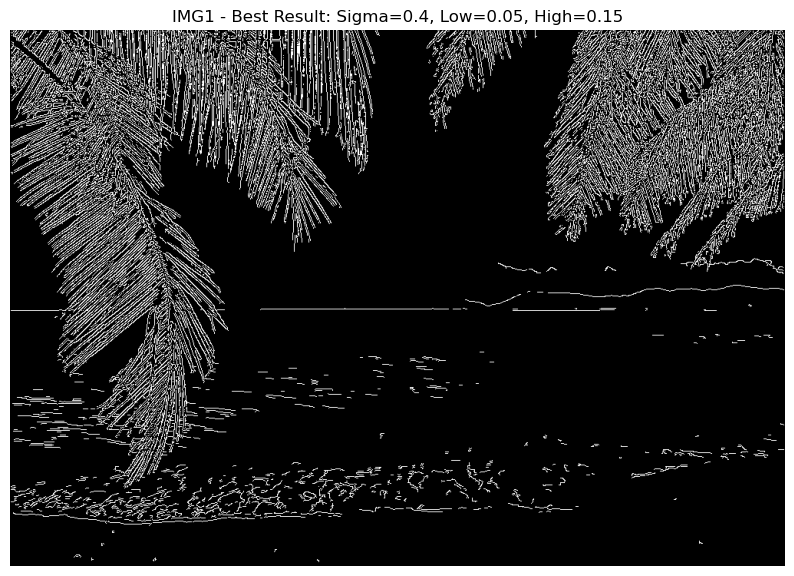

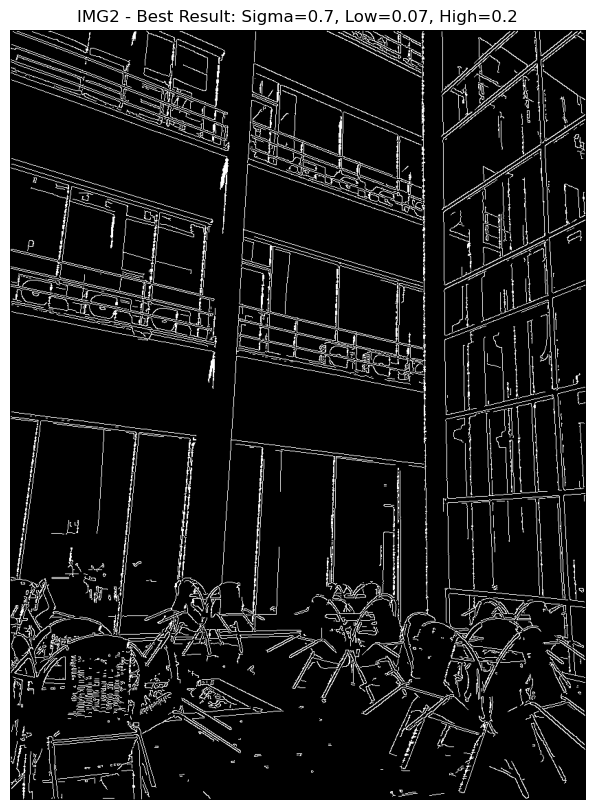

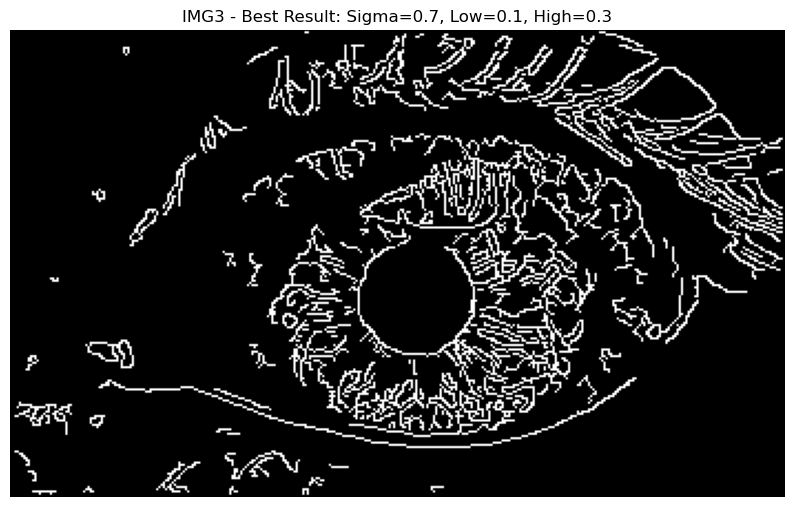

In [37]:
for img_name, params in param_sets.items():
    # 
    best_sigma, best_low, best_high = params[1]
    best_edges = canny_edge_detector(images[img_name], best_sigma, best_low, best_high, k=2)
    
    # Plot the best result in a larger figure
    plt.figure(figsize=(10, 10))
    plt.title(f'{img_name.upper()} - Best Result: Sigma={best_sigma}, Low={best_low}, High={best_high}')
    plt.axis('off')
    plt.imshow(best_edges, cmap='gray')
    plt.show()

### 5.2.1: TEST RUNS

Below are all test runs for the 3 edge images

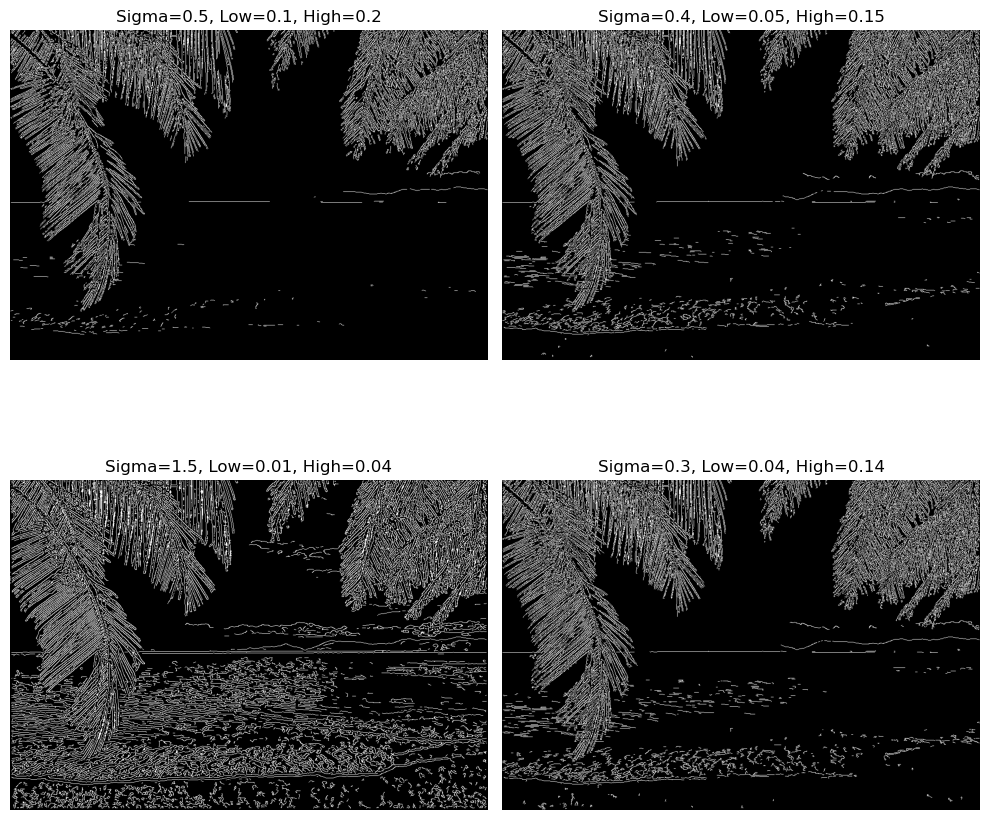

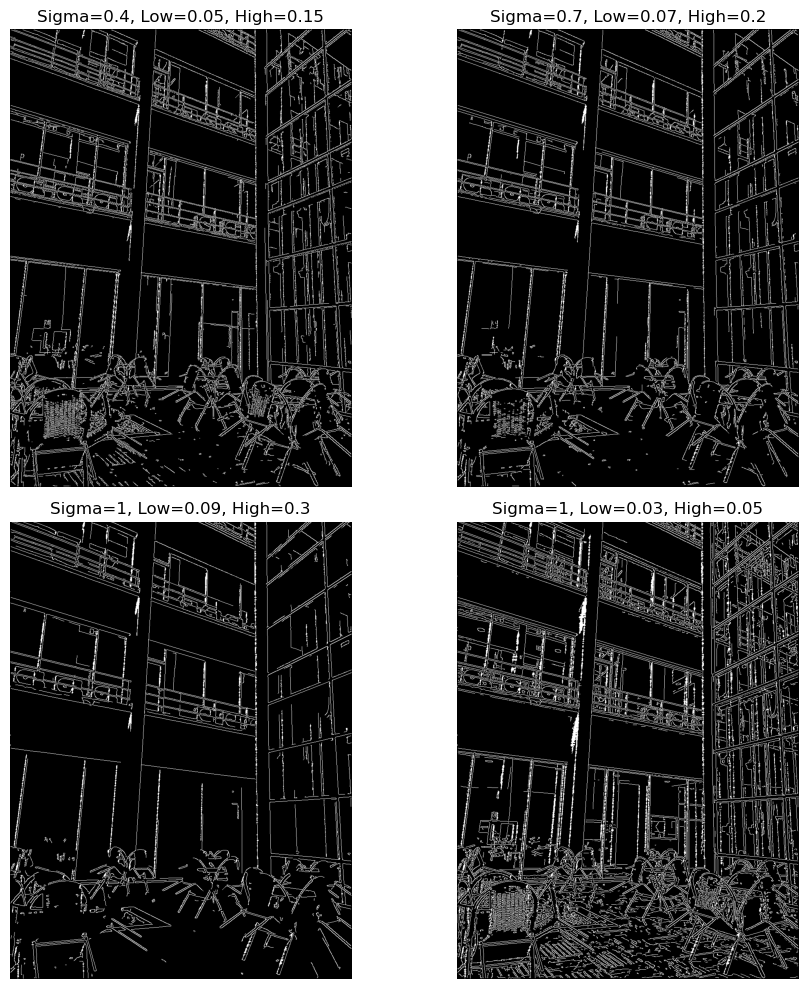

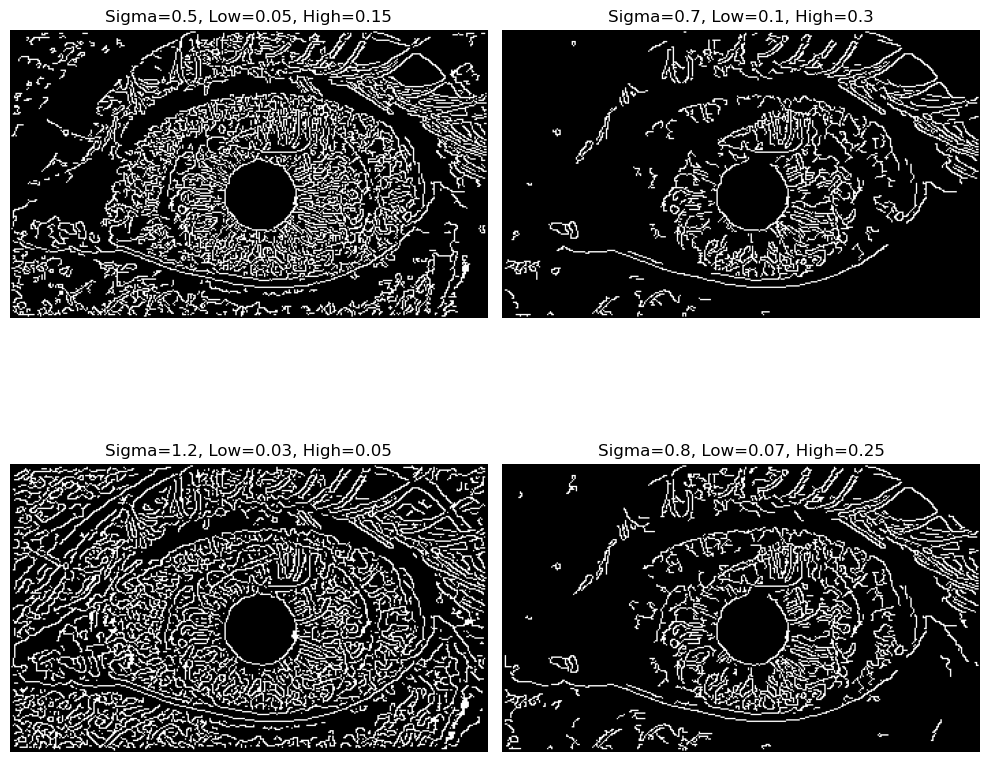

In [38]:
# ****note takes some time as it is running canny on 3 imaages 4 times****
#loop over each image and its corresponding parameters
for img_name, params in param_sets.items():
    # to store results and titles so we can pass to plotter function
    results = []
    titles = []
    for i, (sigma, low, high) in enumerate(params):
        #apply the Canny Edge Detector with the current set of parameters
        edges = canny_edge_detector(images[img_name], sigma, low, high, k=2)
        #append results and title with params values
        results.append(edges)
        titles.append(f'Sigma={sigma}, Low={low}, High={high}')
    
    #plot all test results in a 2x2 grid
    plot_canny_tests(results, titles, figsize_=(10, 10))


### 5.2.1: Canny vs Sobel

The Sobel operator is a simple gradient-based edge detector that identifies areas of high gradient in an image. The Canny edge detector enhances this by incorporating additional steps such as Gaussian smoothing to reduce noise, non-maximum suppression to thin out the edges, and hysteresis as we have implemented. Comparing the results it is obviouse that the Canny edge detector provides a cleaner and more connected edge map with fewer false positives and better continuity in significant edges. We can also see the edges much more sharper than what comes from sobel operator. The improvement in edge detection quality with the Canny method is due to its multi-stage process that really works on the edge detection through each successive step resulting in a more accurate representation of the true edges in the image.

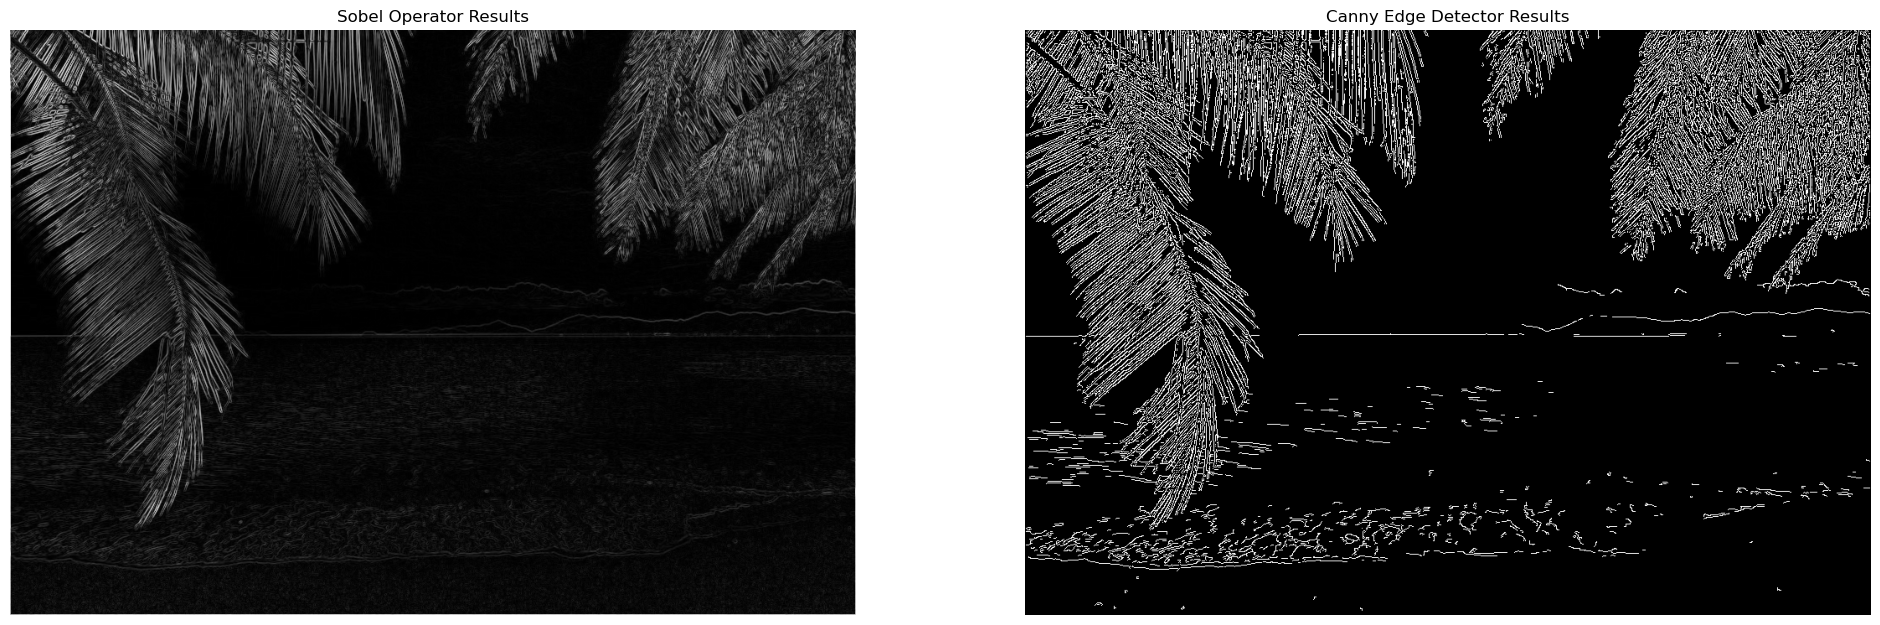

In [39]:
# Apply Canny edge detector with best parameters for img1
best_sigma, best_low, best_high = param_sets['img1'][1]  #best canny params for edge1 
canny_edges1 = canny_edge_detector(img1, best_sigma, best_low, best_high, k=2)

#display results side by side using an example edge1
plt.figure(figsize=(24, 12))
plt.subplot(1, 2, 1)
plt.title('Sobel Operator Results')
plt.axis('off')
plt.imshow(sobel_magnitudes1, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Canny Edge Detector Results')
plt.axis('off')
plt.imshow(canny_edges1, cmap='gray')
plt.show()